In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns
import sys
sys.path.append("../src/hy")
import c_lib
sns.set()

In [2]:
def sim_statndard_Bm(ts: np.ndarray, rng: np.random.Generator) -> np.ndarray:
    """0スタートの標準ブラウン運動のシミュレーション

    Args:
        ts (np.ndarray): 観測時刻の列
        rng (np.random.Generator): 乱数生成器

    Returns:
        np.ndarray: ブラウン運動のシミュレーション結果
    """
    return np.cumsum(np.sqrt(np.diff(ts, prepend=0))*rng.normal(size=len(ts)))

In [3]:
def sim_Poisson_process(lam: float, T: float, rng: np.random.Generator) -> np.ndarray:
    """定常ポアソン過程のシミュレーション

    Args:
        lam (float): >0, 強度
        T (float): >0, シミュレーション時間
        rng (np.random.Generator): 乱数生成器

    Returns:
        np.ndarray: ジャンプ時刻の列
    """
    uniform_rvs = rng.uniform(0, T, size=rng.poisson(lam=int(T*lam)))
    return np.sort(uniform_rvs)

In [4]:
def sim_async_Bm(sig1, sig2, rho, tx, ty, rng):
    common_idx = np.argsort(np.concatenate([tx, ty]))
    common_t = np.concatenate([tx, ty])[common_idx]
    b1 = sim_statndard_Bm(common_t, rng) * sig1
    b2 = sim_statndard_Bm(common_t, rng) * sig2
    # txに該当する部分だけ抽出
    x = b1[common_idx < len(tx)]
    # tyに該当する部分だけ抽出
    y = rho*b1 + np.sqrt(1-rho**2) * b2
    y = y[common_idx >= len(tx)]
    return [x, y]

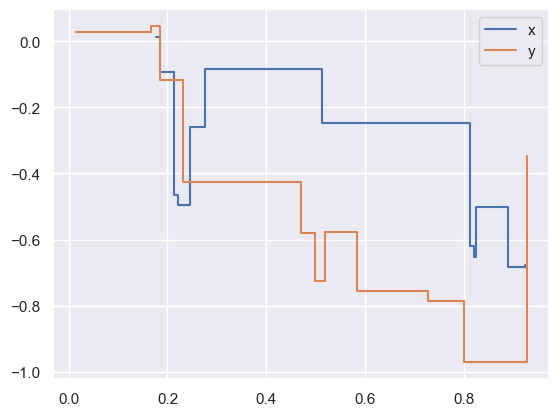

In [5]:
rng = np.random.default_rng(123)
T = 1
tx = sim_Poisson_process(10, T, rng)
ty = sim_Poisson_process(10, T, rng)

x, y = sim_async_Bm(1, 1, 0.5, tx, ty, rng)
plt.step(tx, x, label="x", where="post")
plt.step(ty, y, label="y", where="post")
grid = np.linspace(0.1, 1, 10)
plt.legend()

0.6172983813215229
0.220416669493058
0.21400462778719714


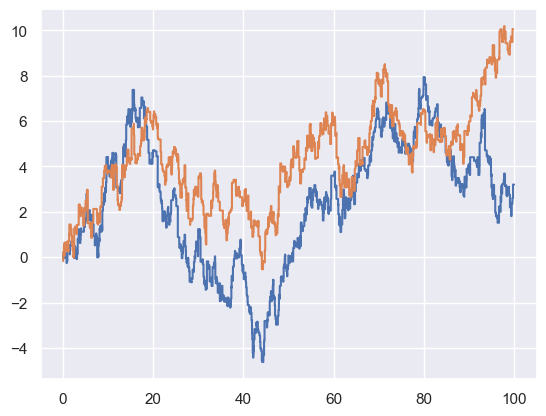

In [6]:
rng = np.random.default_rng(123)
T = 100
lam = 10
h = 1 / 10
tx = sim_Poisson_process(lam, T, rng)
ty = sim_Poisson_process(lam, T, rng)
x, y = sim_async_Bm(1, 1, 0.7, tx, ty, rng)
plt.step(tx, x)
plt.step(ty, y)

print(c_lib.hy([tx, x], [ty, y]) / T)

# previous-tick interpolation
grid = np.linspace(0, T, int(T/h))
ip_x = scipy.interpolate.interp1d(tx, x, 
                                  kind="previous", 
                                  assume_sorted=True,
                                  bounds_error=False, 
                                  fill_value=(x[0], x[-1])
                                  )(grid)
ip_y = scipy.interpolate.interp1d(ty, y, 
                                  kind="previous", 
                                  assume_sorted=True,
                                  bounds_error=False, 
                                  fill_value=(y[0], y[-1])
                                  )(grid)
print(c_lib.hy([grid, ip_x], [grid, ip_y]) / T)

# linear interpolation
ip_x = scipy.interpolate.interp1d(tx, x, 
                                  kind="linear", 
                                  assume_sorted=True,
                                  bounds_error=False, 
                                  fill_value=(x[0], x[-1])
                                  )(grid)
ip_y = scipy.interpolate.interp1d(ty, y, 
                                  kind="linear", 
                                  assume_sorted=True,
                                  bounds_error=False, 
                                  fill_value=(y[0], y[-1])
                                  )(grid)
print(c_lib.hy([grid, ip_x], [grid, ip_y]) / T)

/Users/shiotanitenshou/Research/projects/HY_cce/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shiotanitenshou/Research/projects/HY_cce/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shiotanitenshou/Research/projects/HY_cce/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shiotanitenshou/Research/projects/HY_cce/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: Fut

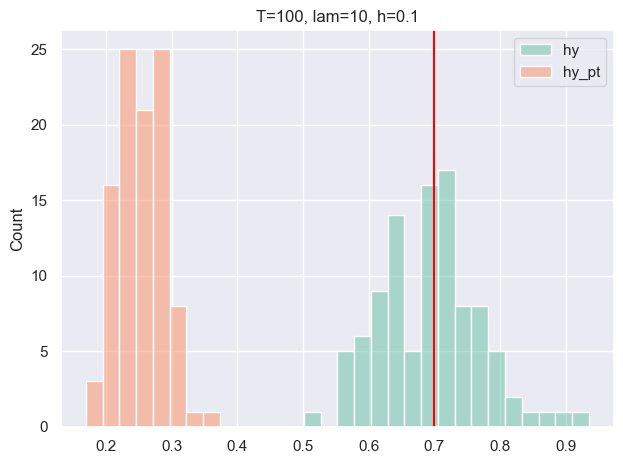

In [7]:
MC = 100
T = 100
lam = 10
h = 1/10
rho = 0.7
rng = np.random.default_rng(123)
grid = np.linspace(0, T, int(T/h))
res_hy = []
res_hy_pt = []
for _ in range(MC):
    tx = sim_Poisson_process(lam, T, rng)
    ty = sim_Poisson_process(lam, T, rng)
    x, y = sim_async_Bm(1, 1, rho, tx, ty, rng)
    ip_x = scipy.interpolate.interp1d(tx, x, 
                                    kind="previous", 
                                    assume_sorted=True,
                                    bounds_error=False, 
                                    fill_value=(x[0], x[-1])
                                    )(grid)
    ip_y = scipy.interpolate.interp1d(ty, y, 
                                    kind="previous", 
                                    assume_sorted=True,
                                    bounds_error=False, 
                                    fill_value=(y[0], y[-1])
                                    )(grid)
    
    res_hy.append(c_lib.hy([tx, x], [ty, y]) / T)
    res_hy_pt.append(c_lib.hy([grid, ip_x], [grid, ip_y]) / T)


plot_df = pd.DataFrame({"hy": res_hy, "hy_pt": res_hy_pt})
fig, ax = plt.subplots(1, 1)
sns.histplot(data=plot_df, bins=30, ax=ax, palette="Set2")
ax.axvline(x=rho, color="red", label="True")
ax.set_title(f"T={T}, lam={lam}, h={h}")
fig.tight_layout()

/Users/shiotanitenshou/Research/projects/HY_cce/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shiotanitenshou/Research/projects/HY_cce/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shiotanitenshou/Research/projects/HY_cce/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shiotanitenshou/Research/projects/HY_cce/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: Fut

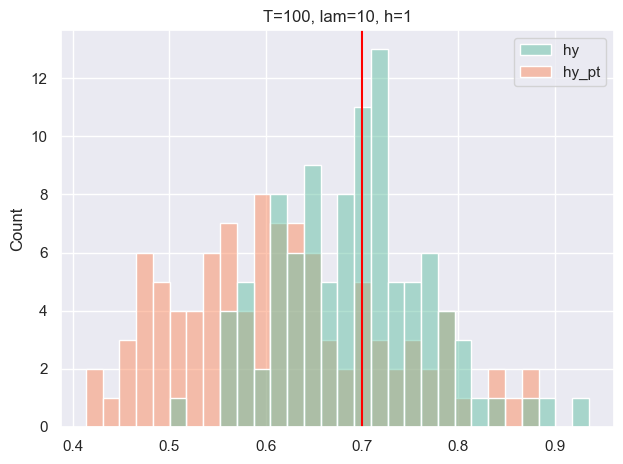

In [8]:
MC = 100
T = 100
lam = 10
h = 1
rho = 0.7
rng = np.random.default_rng(123)
grid = np.linspace(0, T, int(T/h))
res_hy = []
res_hy_pt = []
for _ in range(MC):
    tx = sim_Poisson_process(lam, T, rng)
    ty = sim_Poisson_process(lam, T, rng)
    x, y = sim_async_Bm(1, 1, rho, tx, ty, rng)
    ip_x = scipy.interpolate.interp1d(tx, x, 
                                    kind="previous", 
                                    assume_sorted=True,
                                    bounds_error=False, 
                                    fill_value=(x[0], x[-1])
                                    )(grid)
    ip_y = scipy.interpolate.interp1d(ty, y, 
                                    kind="previous", 
                                    assume_sorted=True,
                                    bounds_error=False, 
                                    fill_value=(y[0], y[-1])
                                    )(grid)
    
    res_hy.append(c_lib.hy([tx, x], [ty, y]) / T)
    res_hy_pt.append(c_lib.hy([grid, ip_x], [grid, ip_y]) / T)


plot_df = pd.DataFrame({"hy": res_hy, "hy_pt": res_hy_pt})
fig, ax = plt.subplots(1, 1)
sns.histplot(data=plot_df, bins=30, ax=ax, palette="Set2")
ax.axvline(x=rho, color="red", label="True")
ax.set_title(f"T={T}, lam={lam}, h={h}")
fig.tight_layout()

/Users/shiotanitenshou/Research/projects/HY_cce/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shiotanitenshou/Research/projects/HY_cce/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shiotanitenshou/Research/projects/HY_cce/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shiotanitenshou/Research/projects/HY_cce/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: Fut

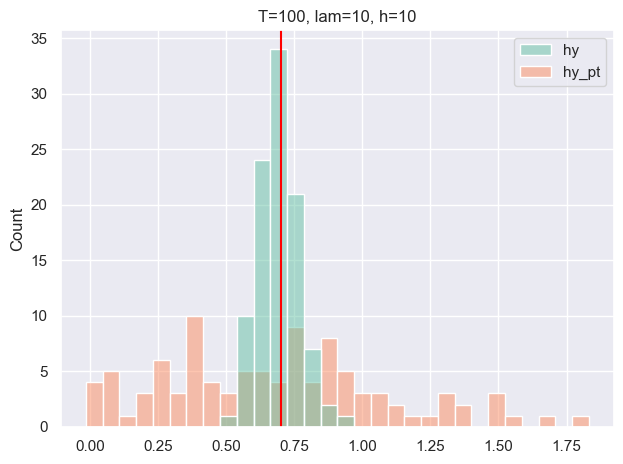

In [9]:
MC = 100
T = 100
lam = 10
h = 10
rho = 0.7
rng = np.random.default_rng(123)
grid = np.linspace(0, T, int(T/h))
res_hy = []
res_hy_pt = []
for _ in range(MC):
    tx = sim_Poisson_process(lam, T, rng)
    ty = sim_Poisson_process(lam, T, rng)
    x, y = sim_async_Bm(1, 1, rho, tx, ty, rng)
    ip_x = scipy.interpolate.interp1d(tx, x, 
                                    kind="previous", 
                                    assume_sorted=True,
                                    bounds_error=False, 
                                    fill_value=(x[0], x[-1])
                                    )(grid)
    ip_y = scipy.interpolate.interp1d(ty, y, 
                                    kind="previous", 
                                    assume_sorted=True,
                                    bounds_error=False, 
                                    fill_value=(y[0], y[-1])
                                    )(grid)
    
    res_hy.append(c_lib.hy([tx, x], [ty, y]) / T)
    res_hy_pt.append(c_lib.hy([grid, ip_x], [grid, ip_y]) / T)


plot_df = pd.DataFrame({"hy": res_hy, "hy_pt": res_hy_pt})
fig, ax = plt.subplots(1, 1)
sns.histplot(data=plot_df, bins=30, ax=ax, palette="Set2")
ax.axvline(x=rho, color="red", label="True")
ax.set_title(f"T={T}, lam={lam}, h={h}")
fig.tight_layout()